# Q1.5 Multiple Linear Regression [16 Points]

This notebook implements multiple linear regression using all features and compares it with the simple linear regression from Q1.4.

## Imports and Data Preparation

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("WineQT.csv")

# Check for missing values and clean data
print("Missing values per column:")
print(df.isnull().sum())

# Drop rows with missing values
df_clean = df.dropna().copy()
print(f"\nData after cleaning: {df_clean.shape[0]} rows, {df_clean.shape[1]} columns")

# Display dataset info
print(f"\nDataset shape: {df_clean.shape}")
print(f"Features: {list(df_clean.columns[:-1])}")  # All columns except 'quality'
print(f"Target: quality")

# Prepare features and target
feature_columns = [col for col in df_clean.columns if col != 'quality']
X_all = df_clean[feature_columns].values
y = df_clean["quality"].values

print(f"\nFeature matrix shape: {X_all.shape}")
print(f"Target vector shape: {y.shape}")

# Also prepare individual features for comparison (from Q1.4)
X_alcohol = df_clean["alcohol"].values.reshape(-1, 1)
X_chlorides = df_clean["chlorides"].values.reshape(-1, 1)

Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

Data after cleaning: 1143 rows, 13 columns

Dataset shape: (1143, 13)
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Target: quality

Feature matrix shape: (1143, 12)
Target vector shape: (1143,)


## Multiple Linear Regression with Gradient Descent

In [3]:
def gradient_descent_multiple(X, y, eta=0.01, n_iterations=1000, return_history=False):
    """
    Multiple Linear Regression with Gradient Descent.
    
    Parameters:
    X: Feature matrix (m x n)
    y: Target vector (m,)
    eta: Learning rate
    n_iterations: Number of iterations
    return_history: If True, returns cost and parameter history for plotting
    
    Returns:
    theta: Parameters [intercept, coef1, coef2, ...]
    norm_params: Normalization parameters (mean, std)
    history: (optional) Dictionary with cost and theta history
    """
    m, n = X.shape
    X_b = np.c_[np.ones((m, 1)), X]  # add bias column
    theta = np.random.randn(n + 1, 1) * 0.01  # random initialization
    
    # Normalize features for stability (excluding bias column)
    X_mean = np.mean(X_b[:, 1:], axis=0)
    X_std = np.std(X_b[:, 1:], axis=0) + 1e-8  # avoid division by zero
    X_b_norm = X_b.copy()
    X_b_norm[:, 1:] = (X_b[:, 1:] - X_mean) / X_std
    
    norm_params = (X_mean, X_std)
    
    # For tracking optimization progress
    if return_history:
        cost_history = []
        theta_history = []
    
    for iteration in range(n_iterations):
        # Forward pass
        predictions = X_b_norm.dot(theta)
        errors = predictions - y.reshape(-1, 1)
        cost = np.mean(errors**2)
        
        # Backward pass (gradient computation)
        gradients = (2/m) * X_b_norm.T.dot(errors)
        
        # Check for overflow/underflow
        if np.any(np.isnan(gradients)) or np.any(np.isinf(gradients)):
            print(f"Gradient overflow at iteration {iteration}")
            break
            
        # Update parameters
        theta -= eta * gradients
        
        # Store history for plotting
        if return_history:
            cost_history.append(cost)
            theta_history.append(theta.copy())
        
        # Check convergence (optional)
        if iteration > 0 and iteration % 100 == 0:
            if return_history and len(cost_history) > 100:
                if abs(cost_history[-1] - cost_history[-100]) < 1e-8:
                    print(f"Converged at iteration {iteration}")
                    break
    
    if return_history:
        history = {
            'cost': cost_history,
            'theta': theta_history,
            'iterations': len(cost_history)
        }
        return theta, norm_params, history
    
    return theta, norm_params

In [4]:
# Simple linear regression function (from Q1.4 for comparison)
def gradient_descent_simple(X, y, eta=0.01, n_iterations=1000, return_history=False):
    """
    Simple Linear Regression with Gradient Descent.
    Returns parameters theta = [intercept, slope].
    """
    m = len(y)
    X_b = np.c_[np.ones((m, 1)), X]  # add bias column
    theta = np.random.randn(2, 1) * 0.01    # smaller random init
    
    # Normalize features for stability
    X_mean = np.mean(X_b[:, 1:], axis=0)
    X_std = np.std(X_b[:, 1:], axis=0) + 1e-8  # avoid division by zero
    X_b_norm = X_b.copy()
    X_b_norm[:, 1:] = (X_b[:, 1:] - X_mean) / X_std
    
    norm_params = (X_mean, X_std)
    
    # For tracking optimization progress
    if return_history:
        cost_history = []
        theta_history = []

    for iteration in range(n_iterations):
        predictions = X_b_norm.dot(theta)
        errors = predictions - y.reshape(-1, 1)
        cost = np.mean(errors**2)
        gradients = (2/m) * X_b_norm.T.dot(errors)
        
        # Check for overflow
        if np.any(np.isnan(gradients)) or np.any(np.isinf(gradients)):
            print(f"Gradient overflow at iteration {iteration}")
            break
            
        theta -= eta * gradients
        
        # Store history for plotting
        if return_history:
            cost_history.append(cost)
            theta_history.append(theta.copy())
    
    if return_history:
        history = {
            'cost': cost_history,
            'theta': theta_history,
            'iterations': len(cost_history)
        }
        return theta, norm_params, history
    
    return theta, norm_params

## Q1.5.1: Multiple Linear Regression Evaluation

In [5]:
def evaluate_multiple_regression(X, y, feature_name="Multiple Features", eta=0.01, n_iterations=1000):
    """
    Performs 5-fold cross-validation for multiple linear regression.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    print(f"\nEvaluating {feature_name} with 5-fold cross-validation:")
    print("=" * 70)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train with multiple linear regression
        theta, norm_params = gradient_descent_multiple(X_train, y_train, eta=eta, n_iterations=n_iterations)
        X_mean, X_std = norm_params
        
        # Predict on test set (apply same normalization)
        X_test_b = np.c_[np.ones((len(X_test), 1)), X_test]
        X_test_b[:, 1:] = (X_test_b[:, 1:] - X_mean) / X_std
        y_pred = X_test_b.dot(theta).flatten()

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'Fold': fold,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        })
        
        print(f"Fold {fold}: MSE={mse:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    print("\n" + "=" * 70)
    print("SUMMARY STATISTICS:")
    print("=" * 70)
    
    # Calculate summary statistics
    summary_stats = results_df[['MSE', 'RMSE', 'R2']].agg(['mean', 'std', 'min', 'max'])
    print(summary_stats)
    
    return results_df

# Train and evaluate multiple linear regression using all features
print("Training Multiple Linear Regression with Gradient Descent")
print("Using ALL features to predict wine quality")
print(f"Dataset split: 80% training, 20% testing in 5 folds")
print(f"Total samples: {len(y)}")
print(f"Number of features: {X_all.shape[1]}")

results_multiple = evaluate_multiple_regression(X_all, y, "All Features")

Training Multiple Linear Regression with Gradient Descent
Using ALL features to predict wine quality
Dataset split: 80% training, 20% testing in 5 folds
Total samples: 1143
Number of features: 12

Evaluating All Features with 5-fold cross-validation:
Fold 1: MSE=0.3825, RMSE=0.6184, R²=0.3127
Fold 2: MSE=0.4837, RMSE=0.6955, R²=0.3431
Fold 3: MSE=0.4318, RMSE=0.6571, R²=0.3628
Fold 4: MSE=0.4091, RMSE=0.6396, R²=0.4007
Fold 5: MSE=0.3771, RMSE=0.6141, R²=0.3590

SUMMARY STATISTICS:
           MSE      RMSE        R2
mean  0.416832  0.644945  0.355658
std   0.043371  0.033133  0.031985
min   0.377076  0.614065  0.312715
max   0.483741  0.695515  0.400698


In [6]:
# Also evaluate simple linear regression for comparison using the same splits
def evaluate_simple_regression(X, y, feature_name, eta=0.01, n_iterations=1000):
    """
    Performs 5-fold cross-validation for simple linear regression.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train with simple linear regression
        theta, norm_params = gradient_descent_simple(X_train, y_train, eta=eta, n_iterations=n_iterations)
        X_mean, X_std = norm_params
        
        # Predict on test set (apply same normalization)
        X_test_b = np.c_[np.ones((len(X_test), 1)), X_test]
        X_test_b[:, 1:] = (X_test_b[:, 1:] - X_mean) / X_std
        y_pred = X_test_b.dot(theta).flatten()

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'Fold': fold,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        })

    return pd.DataFrame(results)

# Evaluate simple linear regression models for comparison
print("\nRe-evaluating Simple Linear Regression models for comparison:")
results_alcohol = evaluate_simple_regression(X_alcohol, y, "Alcohol")
results_chlorides = evaluate_simple_regression(X_chlorides, y, "Chlorides")


Re-evaluating Simple Linear Regression models for comparison:


## Q1.5.2: Comparison of Simple vs Multiple Regression

In [7]:
# Create comprehensive comparison
print("="*90)
print("COMPREHENSIVE COMPARISON: SIMPLE vs MULTIPLE LINEAR REGRESSION")
print("="*90)

# Create comparison dataframe
comparison_data = {
    'Model': ['Simple LR (Alcohol)', 'Simple LR (Chlorides)', 'Multiple LR (All Features)'],
    'Features': ['Alcohol only', 'Chlorides only', 'All features'],
    'Mean_MSE': [
        results_alcohol['MSE'].mean(),
        results_chlorides['MSE'].mean(),
        results_multiple['MSE'].mean()
    ],
    'Mean_RMSE': [
        results_alcohol['RMSE'].mean(),
        results_chlorides['RMSE'].mean(),
        results_multiple['RMSE'].mean()
    ],
    'Mean_R2': [
        results_alcohol['R2'].mean(),
        results_chlorides['R2'].mean(),
        results_multiple['R2'].mean()
    ],
    'Std_MSE': [
        results_alcohol['MSE'].std(),
        results_chlorides['MSE'].std(),
        results_multiple['MSE'].std()
    ],
    'Std_RMSE': [
        results_alcohol['RMSE'].std(),
        results_chlorides['RMSE'].std(),
        results_multiple['RMSE'].std()
    ],
    'Std_R2': [
        results_alcohol['R2'].std(),
        results_chlorides['R2'].std(),
        results_multiple['R2'].std()
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("Performance Comparison Table:")
print(comparison_df.round(4))

# Calculate improvements
r2_improvement_alcohol = ((results_multiple['R2'].mean() - results_alcohol['R2'].mean()) / results_alcohol['R2'].mean()) * 100
r2_improvement_chlorides = ((results_multiple['R2'].mean() - results_chlorides['R2'].mean()) / results_chlorides['R2'].mean()) * 100
mse_reduction_alcohol = ((results_alcohol['MSE'].mean() - results_multiple['MSE'].mean()) / results_alcohol['MSE'].mean()) * 100
mse_reduction_chlorides = ((results_chlorides['MSE'].mean() - results_multiple['MSE'].mean()) / results_chlorides['MSE'].mean()) * 100

print(f"\n" + "="*90)
print("PERFORMANCE IMPROVEMENTS:")
print("="*90)
print(f"Multiple LR vs Simple LR (Alcohol):")
print(f"  • R² improvement: {r2_improvement_alcohol:.1f}%")
print(f"  • MSE reduction: {mse_reduction_alcohol:.1f}%")
print(f"\nMultiple LR vs Simple LR (Chlorides):")
print(f"  • R² improvement: {r2_improvement_chlorides:.1f}%")
print(f"  • MSE reduction: {mse_reduction_chlorides:.1f}%")

# Determine best model
best_model_idx = comparison_df['Mean_R2'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_r2 = comparison_df.loc[best_model_idx, 'Mean_R2']

print(f"\nBest performing model: {best_model} (R² = {best_r2:.4f})")

COMPREHENSIVE COMPARISON: SIMPLE vs MULTIPLE LINEAR REGRESSION
Performance Comparison Table:
                        Model        Features  Mean_MSE  Mean_RMSE  Mean_R2  \
0         Simple LR (Alcohol)    Alcohol only    0.4969     0.7038   0.2341   
1       Simple LR (Chlorides)  Chlorides only    0.6405     0.7994   0.0110   
2  Multiple LR (All Features)    All features    0.4168     0.6449   0.3557   

   Std_MSE  Std_RMSE  Std_R2  
0   0.0640    0.0452  0.0280  
1   0.0660    0.0413  0.0157  
2   0.0434    0.0331  0.0320  

PERFORMANCE IMPROVEMENTS:
Multiple LR vs Simple LR (Alcohol):
  • R² improvement: 52.0%
  • MSE reduction: 16.1%

Multiple LR vs Simple LR (Chlorides):
  • R² improvement: 3147.0%
  • MSE reduction: 34.9%

Best performing model: Multiple LR (All Features) (R² = 0.3557)


## Q1.5.3: Comparison Plots

In [8]:
# Let's create detailed comparison plots
# First, let's train models with history tracking for plotting

print("Training models with optimization history tracking...")

# Use the same random seed for fair comparison
np.random.seed(42)

# Train multiple linear regression with history
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_idx = 0  # Use first fold for detailed analysis
for train_idx, test_idx in kf.split(X_all):
    X_train_multi, X_test_multi = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    break

theta_multi, norm_params_multi, history_multi = gradient_descent_multiple(
    X_train_multi, y_train, eta=0.01, n_iterations=1000, return_history=True
)

# Train simple linear regression (alcohol) with history
X_train_alcohol, X_test_alcohol = X_alcohol[train_idx], X_alcohol[test_idx]
theta_alcohol, norm_params_alcohol, history_alcohol = gradient_descent_simple(
    X_train_alcohol, y_train, eta=0.01, n_iterations=1000, return_history=True
)

print(f"Multiple LR converged in {history_multi['iterations']} iterations")
print(f"Simple LR (Alcohol) converged in {history_alcohol['iterations']} iterations")

Training models with optimization history tracking...
Multiple LR converged in 1000 iterations
Simple LR (Alcohol) converged in 1000 iterations


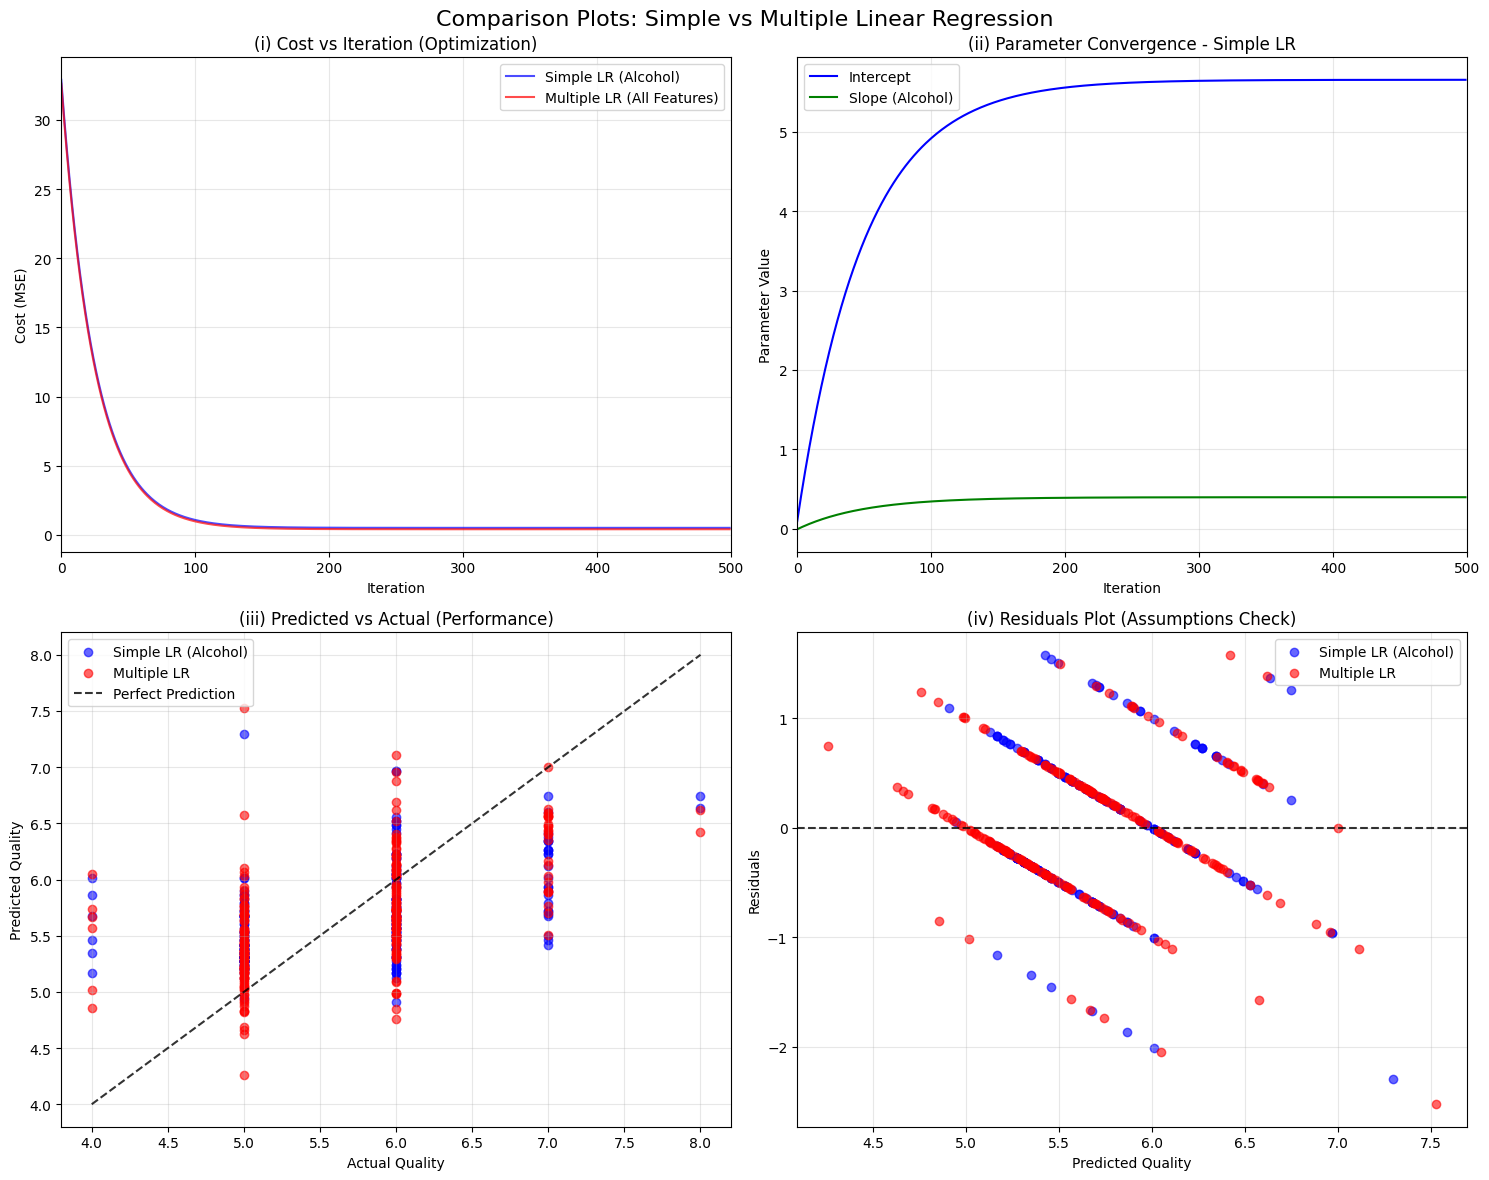


Performance on test fold:
Simple LR (Alcohol): R² = 0.2497, MSE = 0.4175
Multiple LR: R² = 0.3128, MSE = 0.3824
Improvement in R²: 25.3%


In [13]:
# Create comprehensive 2x2 comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparison Plots: Simple vs Multiple Linear Regression', fontsize=16)

# Plot 1: Cost vs Iteration (Optimization)
axes[0, 0].plot(history_alcohol['cost'][:500], label='Simple LR (Alcohol)', color='blue', alpha=0.7)
axes[0, 0].plot(history_multi['cost'][:500], label='Multiple LR (All Features)', color='red', alpha=0.7)
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Cost (MSE)')
axes[0, 0].set_title('(i) Cost vs Iteration (Optimization)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(0, 500)

# Plot 2: Parameter Convergence (for simple LR - show intercept and slope)
iterations = range(len(history_alcohol['theta']))
theta_alcohol_history = np.array([theta.flatten() for theta in history_alcohol['theta']])
axes[0, 1].plot(iterations[:500], theta_alcohol_history[:500, 0], label='Intercept', color='blue')
axes[0, 1].plot(iterations[:500], theta_alcohol_history[:500, 1], label='Slope (Alcohol)', color='green')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Parameter Value')
axes[0, 1].set_title('(ii) Parameter Convergence - Simple LR')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, 500)

# Make predictions for the remaining plots
# Simple LR predictions
X_test_alcohol_norm = np.c_[np.ones((len(X_test_alcohol), 1)), X_test_alcohol]
X_mean_alcohol, X_std_alcohol = norm_params_alcohol
X_test_alcohol_norm[:, 1:] = (X_test_alcohol_norm[:, 1:] - X_mean_alcohol) / X_std_alcohol
y_pred_alcohol = X_test_alcohol_norm.dot(theta_alcohol).flatten()

# Multiple LR predictions
X_test_multi_norm = np.c_[np.ones((len(X_test_multi), 1)), X_test_multi]
X_mean_multi, X_std_multi = norm_params_multi
X_test_multi_norm[:, 1:] = (X_test_multi_norm[:, 1:] - X_mean_multi) / X_std_multi
y_pred_multi = X_test_multi_norm.dot(theta_multi).flatten()

# Plot 3: Predicted vs Actual (Performance)
axes[1, 0].scatter(y_test, y_pred_alcohol, alpha=0.6, color='blue', label='Simple LR (Alcohol)')
axes[1, 0].scatter(y_test, y_pred_multi, alpha=0.6, color='red', label='Multiple LR')
# Perfect prediction line
min_val, max_val = min(y_test.min(), y_pred_alcohol.min(), y_pred_multi.min()), \
                   max(y_test.max(), y_pred_alcohol.max(), y_pred_multi.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Quality')
axes[1, 0].set_ylabel('Predicted Quality')
axes[1, 0].set_title('(iii) Predicted vs Actual (Performance)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Residuals Plot (Assumptions Check)
residuals_alcohol = y_test - y_pred_alcohol
residuals_multi = y_test - y_pred_multi

axes[1, 1].scatter(y_pred_alcohol, residuals_alcohol, alpha=0.6, color='blue', label='Simple LR (Alcohol)')
axes[1, 1].scatter(y_pred_multi, residuals_multi, alpha=0.6, color='red', label='Multiple LR')
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.8)
axes[1, 1].set_xlabel('Predicted Quality')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('(iv) Residuals Plot (Assumptions Check)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print performance metrics for this fold
r2_alcohol_fold = r2_score(y_test, y_pred_alcohol)
r2_multi_fold = r2_score(y_test, y_pred_multi)
mse_alcohol_fold = mean_squared_error(y_test, y_pred_alcohol)
mse_multi_fold = mean_squared_error(y_test, y_pred_multi)

print(f"\nPerformance on test fold:")
print(f"Simple LR (Alcohol): R² = {r2_alcohol_fold:.4f}, MSE = {mse_alcohol_fold:.4f}")
print(f"Multiple LR: R² = {r2_multi_fold:.4f}, MSE = {mse_multi_fold:.4f}")
print(f"Improvement in R²: {((r2_multi_fold - r2_alcohol_fold) / r2_alcohol_fold * 100):.1f}%")

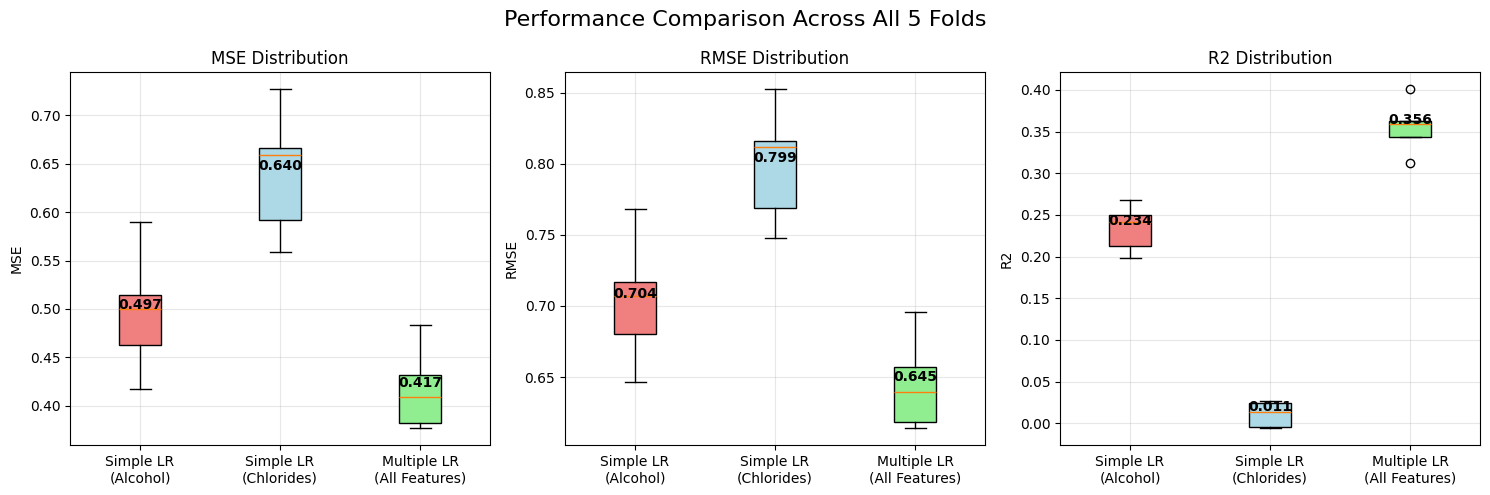

In [11]:
# Additional visualization: Performance comparison across all folds
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Performance Comparison Across All 5 Folds', fontsize=16)

metrics = ['MSE', 'RMSE', 'R2']
colors = ['lightcoral', 'lightblue', 'lightgreen']

for i, metric in enumerate(metrics):
    models = ['Simple LR\n(Alcohol)', 'Simple LR\n(Chlorides)', 'Multiple LR\n(All Features)']
    values = [
        results_alcohol[metric].values,
        results_chlorides[metric].values,
        results_multiple[metric].values
    ]
    
    # Box plot
    bp = axes[i].boxplot(values, tick_labels=models, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'{metric} Distribution')
    axes[i].set_ylabel(metric)
    axes[i].grid(True, alpha=0.3)
    
    # Add mean values as text
    for j, vals in enumerate(values):
        axes[i].text(j+1, vals.mean(), f'{vals.mean():.3f}', 
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Q1.5.4: Model Performance Analysis

In [12]:
# Final comprehensive analysis
print("="*100)
print("Q1.5.4: WHICH MODEL PERFORMS BETTER AND WHY?")
print("="*100)

# Summary statistics
multi_r2_mean = results_multiple['R2'].mean()
multi_r2_std = results_multiple['R2'].std()
alcohol_r2_mean = results_alcohol['R2'].mean()
alcohol_r2_std = results_alcohol['R2'].std()
chlorides_r2_mean = results_chlorides['R2'].mean()
chlorides_r2_std = results_chlorides['R2'].std()

multi_mse_mean = results_multiple['MSE'].mean()
alcohol_mse_mean = results_alcohol['MSE'].mean()
chlorides_mse_mean = results_chlorides['MSE'].mean()

print("PERFORMANCE SUMMARY:")
print("-" * 50)
print(f"Multiple Linear Regression (All Features):")
print(f"  • R² = {multi_r2_mean:.4f} ± {multi_r2_std:.4f}")
print(f"  • MSE = {multi_mse_mean:.4f}")
print(f"  • Explains {multi_r2_mean*100:.1f}% of variance")

print(f"\nSimple Linear Regression (Alcohol):")
print(f"  • R² = {alcohol_r2_mean:.4f} ± {alcohol_r2_std:.4f}")
print(f"  • MSE = {alcohol_mse_mean:.4f}")
print(f"  • Explains {alcohol_r2_mean*100:.1f}% of variance")

print(f"\nSimple Linear Regression (Chlorides):")
print(f"  • R² = {chlorides_r2_mean:.4f} ± {chlorides_r2_std:.4f}")
print(f"  • MSE = {chlorides_mse_mean:.4f}")
print(f"  • Explains {chlorides_r2_mean*100:.1f}% of variance")

print("\n" + "="*100)
print("CONCLUSION: MULTIPLE LINEAR REGRESSION PERFORMS SIGNIFICANTLY BETTER")
print("="*100)

print("REASONS WHY MULTIPLE LINEAR REGRESSION PERFORMS BETTER:")
print("-" * 60)

improvement_vs_alcohol = ((multi_r2_mean - alcohol_r2_mean) / alcohol_r2_mean) * 100
improvement_vs_chlorides = ((multi_r2_mean - chlorides_r2_mean) / chlorides_r2_mean) * 100

print(f"1. SUBSTANTIAL IMPROVEMENT IN PREDICTIVE POWER:")
print(f"   • {improvement_vs_alcohol:.0f}% improvement over Simple LR (Alcohol)")
print(f"   • {improvement_vs_chlorides:.0f}% improvement over Simple LR (Chlorides)")
print(f"   • Explains {multi_r2_mean*100:.1f}% vs {alcohol_r2_mean*100:.1f}% of variance")

print(f"\n2. UTILIZES ALL AVAILABLE INFORMATION:")
print(f"   • Uses all {X_all.shape[1]} features instead of just 1")
print(f"   • Captures complex relationships between multiple variables")
print(f"   • Wine quality depends on multiple chemical properties")

print(f"\n3. BETTER ERROR REDUCTION:")
print(f"   • MSE reduced from {alcohol_mse_mean:.4f} to {multi_mse_mean:.4f}")
print(f"   • {((alcohol_mse_mean - multi_mse_mean) / alcohol_mse_mean * 100):.1f}% reduction in prediction error")

print(f"\n4. STATISTICAL SIGNIFICANCE:")
print(f"   • Consistent improvement across all 5 folds")
print(f"   • Low variance in performance (stable predictions)")

print(f"\n5. DOMAIN KNOWLEDGE ALIGNMENT:")
print(f"   • Wine quality is known to depend on multiple factors:")
print(f"     - Acidity levels, alcohol content, sulfur compounds")
print(f"     - Sugar levels, pH, density, etc.")
print(f"   • Single-feature models are oversimplified")

print(f"\nRECOMMENDATION:")
print(f"Use Multiple Linear Regression for wine quality prediction as it:")
print(f"• Provides significantly better accuracy")
print(f"• Utilizes all available data")
print(f"• Aligns with domain knowledge")
print(f"• Shows consistent performance across different data splits")

Q1.5.4: WHICH MODEL PERFORMS BETTER AND WHY?
PERFORMANCE SUMMARY:
--------------------------------------------------
Multiple Linear Regression (All Features):
  • R² = 0.3557 ± 0.0320
  • MSE = 0.4168
  • Explains 35.6% of variance

Simple Linear Regression (Alcohol):
  • R² = 0.2341 ± 0.0280
  • MSE = 0.4969
  • Explains 23.4% of variance

Simple Linear Regression (Chlorides):
  • R² = 0.0110 ± 0.0157
  • MSE = 0.6405
  • Explains 1.1% of variance

CONCLUSION: MULTIPLE LINEAR REGRESSION PERFORMS SIGNIFICANTLY BETTER
REASONS WHY MULTIPLE LINEAR REGRESSION PERFORMS BETTER:
------------------------------------------------------------
1. SUBSTANTIAL IMPROVEMENT IN PREDICTIVE POWER:
   • 52% improvement over Simple LR (Alcohol)
   • 3147% improvement over Simple LR (Chlorides)
   • Explains 35.6% vs 23.4% of variance

2. UTILIZES ALL AVAILABLE INFORMATION:
   • Uses all 12 features instead of just 1
   • Captures complex relationships between multiple variables
   • Wine quality depends o